In [5]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from tqdm import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

In [6]:
df= pd.read_csv("/kaggle/input/appliances-energy-prediction/KAG_energydata_complete.csv",
                 parse_dates= ["date"], date_format= "%Y-%m-%d %H:%M:%S")#.reset_index()
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [7]:
df.dtypes

date           datetime64[ns]
Appliances              int64
lights                  int64
T1                    float64
RH_1                  float64
T2                    float64
RH_2                  float64
T3                    float64
RH_3                  float64
T4                    float64
RH_4                  float64
T5                    float64
RH_5                  float64
T6                    float64
RH_6                  float64
T7                    float64
RH_7                  float64
T8                    float64
RH_8                  float64
T9                    float64
RH_9                  float64
T_out                 float64
Press_mm_hg           float64
RH_out                float64
Windspeed             float64
Visibility            float64
Tdewpoint             float64
rv1                   float64
rv2                   float64
dtype: object

In [8]:
df.describe()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,2016-03-20 05:30:00,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
min,2016-01-11 17:00:00,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,2016-02-14 23:15:00,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,2016-03-20 05:30:00,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,2016-04-23 11:45:00,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,2016-05-27 18:00:00,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634


In [9]:
#restructuring the columns
df.columns= df.columns.str.lower()
df= df.reindex(columns= sorted(df.columns))
df.head()

,appliances,date,lights,press_mm_hg,rh_1,rh_2,rh_3,rh_4,rh_5,rh_6,rh_7,rh_8,rh_9,rh_out,rv1,rv2,t1,t2,t3,t4,t5,t6,t7,t8,t9,t_out,tdewpoint,visibility,windspeed
0,60,2016-01-11 17:00:00,30,733.5,47.596667,44.790000,44.730000,45.566667,55.20,84.256667,41.626667,48.900000,45.53,92.0,13.275433,13.275433,19.89,19.2,19.79,19.000000,17.166667,7.026667,17.200000,18.2,17.033333,6.600000,5.3,63.000000,7.000000
1,60,2016-01-11 17:10:00,30,733.6,46.693333,44.722500,44.790000,45.992500,55.20,84.063333,41.560000,48.863333,45.56,92.0,18.606195,18.606195,19.89,19.2,19.79,19.000000,17.166667,6.833333,17.200000,18.2,17.066667,6.483333,5.2,59.166667,6.666667
2,50,2016-01-11 17:20:00,30,733.7,46.300000,44.626667,44.933333,45.890000,55.09,83.156667,41.433333,48.730000,45.50,92.0,28.642668,28.642668,19.89,19.2,19.79,18.926667,17.166667,6.560000,17.200000,18.2,17.000000,6.366667,5.1,55.333333,6.333333
3,50,2016-01-11 17:30:00,40,733.8,46.066667,44.590000,45.000000,45.723333,55.09,83.423333,41.290000,48.590000,45.40,92.0,45.410389,45.410389,19.89,19.2,19.79,18.890000,17.166667,6.433333,17.133333,18.1,17.000000,6.250000,5.0,51.500000,6.000000
4,60,2016-01-11 17:40:00,40,733.9,46.333333,44.530000,45.000000,45.530000,55.09,84.893333,41.230000,48.590000,45.40,92.0,10.084097,10.084097,19.89,19.2,19.79,18.890000,17.200000,6.366667,17.200000,18.1,17.000000,6.133333,4.9,47.666667,5.666667


In [10]:
#creating a copy of the original data, that'll be used for model building
df_model= df.copy()
df_model

,appliances,date,lights,press_mm_hg,rh_1,rh_2,rh_3,rh_4,rh_5,rh_6,rh_7,rh_8,rh_9,rh_out,rv1,rv2,t1,t2,t3,t4,t5,t6,t7,t8,t9,t_out,tdewpoint,visibility,windspeed
0,60,2016-01-11 17:00:00,30,733.5,47.596667,44.790000,44.730000,45.566667,55.200000,84.256667,41.626667,48.900000,45.5300,92.000000,13.275433,13.275433,19.890000,19.200000,19.790000,19.000000,17.166667,7.026667,17.200000,18.2000,17.033333,6.600000,5.300000,63.000000,7.000000
1,60,2016-01-11 17:10:00,30,733.6,46.693333,44.722500,44.790000,45.992500,55.200000,84.063333,41.560000,48.863333,45.5600,92.000000,18.606195,18.606195,19.890000,19.200000,19.790000,19.000000,17.166667,6.833333,17.200000,18.2000,17.066667,6.483333,5.200000,59.166667,6.666667
2,50,2016-01-11 17:20:00,30,733.7,46.300000,44.626667,44.933333,45.890000,55.090000,83.156667,41.433333,48.730000,45.5000,92.000000,28.642668,28.642668,19.890000,19.200000,19.790000,18.926667,17.166667,6.560000,17.200000,18.2000,17.000000,6.366667,5.100000,55.333333,6.333333
3,50,2016-01-11 17:30:00,40,733.8,46.066667,44.590000,45.000000,45.723333,55.090000,83.423333,41.290000,48.590000,45.4000,92.000000,45.410389,45.410389,19.890000,19.200000,19.790000,18.890000,17.166667,6.433333,17.133333,18.1000,17.000000,6.250000,5.000000,51.500000,6.000000
4,60,2016-01-11 17:40:00,40,733.9,46.333333,44.530000,45.000000,45.530000,55.090000,84.893333,41.230000,48.590000,45.4000,92.000000,10.084097,10.084097,19.890000,19.200000,19.790000,18.890000,17.200000,6.366667,17.200000,18.1000,17.000000,6.133333,4.900000,47.666667,5.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,2016-05-27 17:20:00,0,755.2,46.560000,42.025714,41.163333,45.590000,52.400000,1.000000,44.500000,50.074000,46.7900,55.666667,43.096812,43.096812,25.566667,25.890000,27.200000,24.700000,23.200000,24.796667,24.500000,24.7000,23.200000,22.733333,13.333333,23.666667,3.333333
19731,90,2016-05-27 17:30:00,0,755.2,46.500000,42.080000,41.223333,45.590000,52.326667,1.000000,44.414286,49.790000,46.7900,56.000000,49.282940,49.282940,25.500000,25.754000,27.133333,24.700000,23.230000,24.196667,24.557143,24.7000,23.200000,22.600000,13.300000,24.500000,3.500000
19732,270,2016-05-27 17:40:00,10,755.2,46.596667,42.768571,41.690000,45.730000,52.266667,1.000000,44.400000,49.660000,46.7900,56.333333,29.199117,29.199117,25.500000,25.628571,27.050000,24.700000,23.230000,23.626667,24.540000,24.7000,23.200000,22.466667,13.266667,25.333333,3.666667
19733,420,2016-05-27 17:50:00,10,755.2,46.990000,43.036000,41.290000,45.790000,52.200000,1.000000,44.295714,49.518750,46.8175,56.666667,6.322784,6.322784,25.500000,25.414000,26.890000,24.700000,23.200000,22.433333,24.500000,24.6625,23.200000,22.333333,13.233333,26.166667,3.833333


In [11]:
df.isnull().sum()

appliances     0
date           0
lights         0
press_mm_hg    0
rh_1           0
rh_2           0
rh_3           0
rh_4           0
rh_5           0
rh_6           0
rh_7           0
rh_8           0
rh_9           0
rh_out         0
rv1            0
rv2            0
t1             0
t2             0
t3             0
t4             0
t5             0
t6             0
t7             0
t8             0
t9             0
t_out          0
tdewpoint      0
visibility     0
windspeed      0
dtype: int64

There are no null values in the dataset

In [12]:
#adding is_weekend column

df.loc[:, "is_weekend"]= np.where(df.loc[:, "date"].dt.dayofweek>4, 1, 0)
df["is_weekend"].value_counts()

is_weekend
0    14263
1     5472
Name: count, dtype: int64

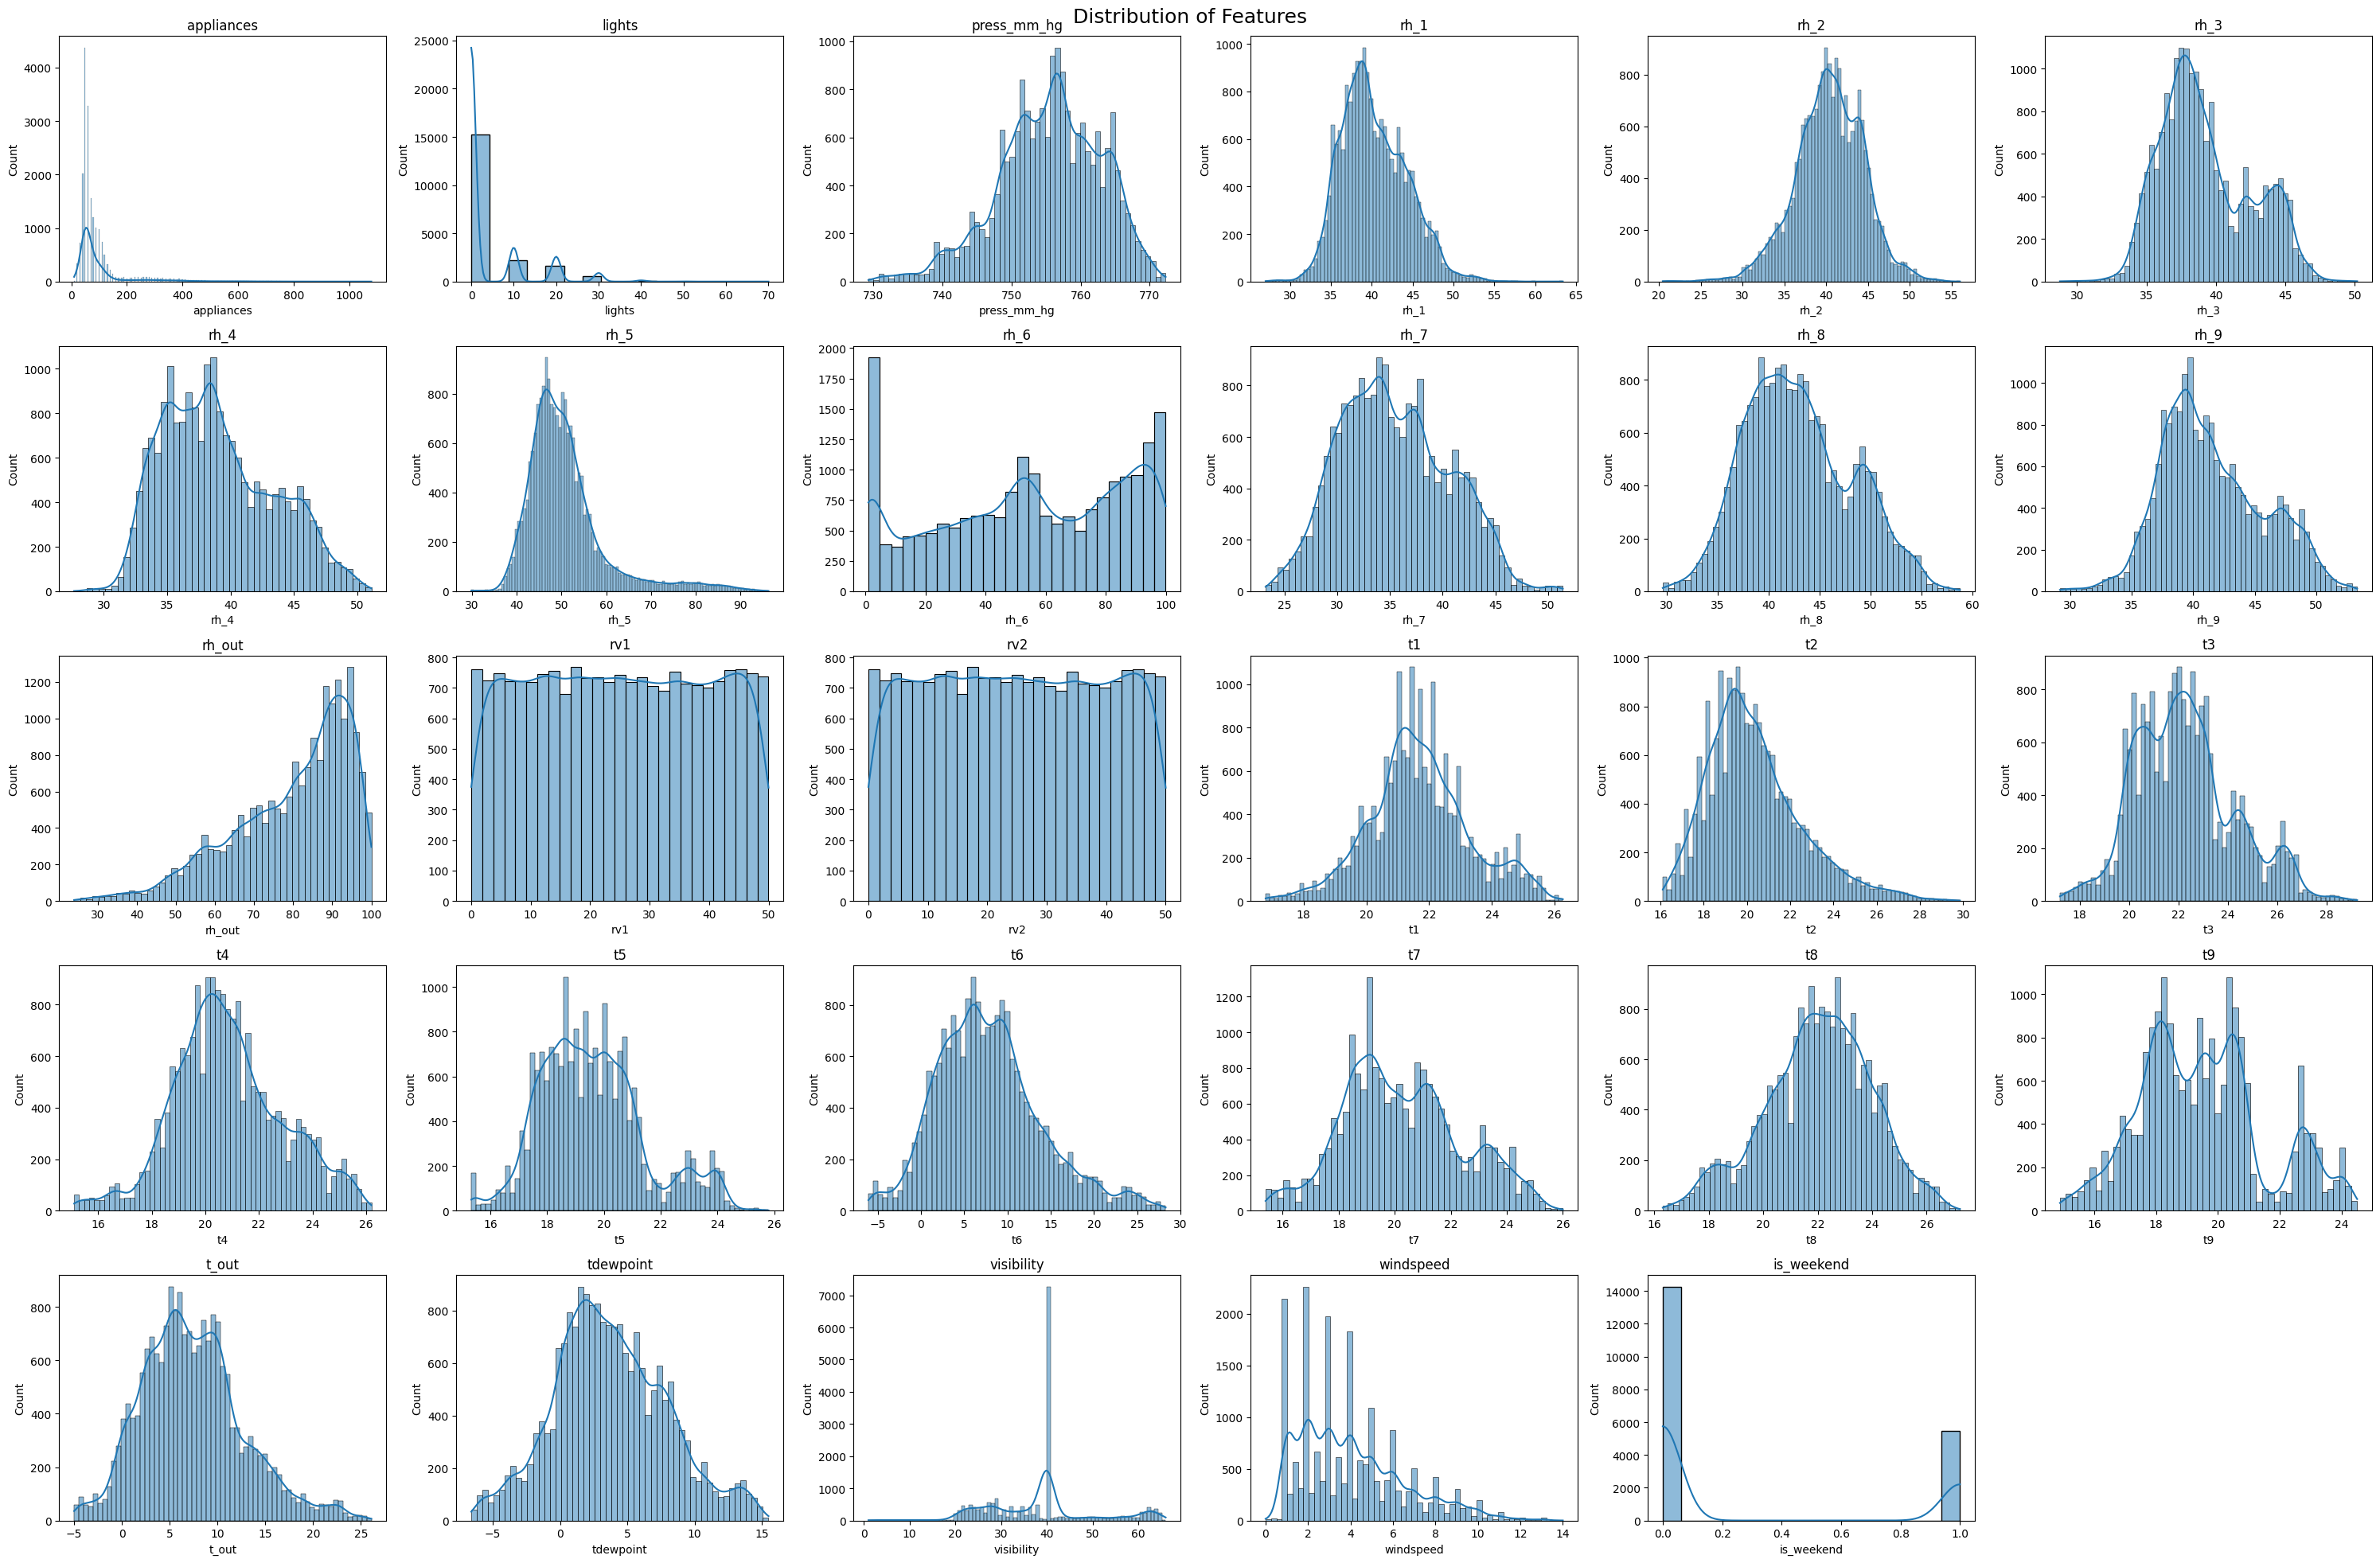

In [13]:
nrows= 5
ncols= int(len(df.columns)/nrows)

fig, axes= plt.subplots(nrows= nrows, ncols= ncols, figsize= (30, 20))
axes= axes.flatten()

# plt.subplots_adjust(hspace=0.05, wspace= 0.0005)


for i, feature in enumerate(df.drop(columns= ["date"]).columns):
    sns.histplot(data= df, x= feature, kde=True, ax= axes[i])
    axes[i].set_title(feature) 

#removing subplots that weren't used
for i in range(len(df.drop(columns= ["date"]).columns), nrows * ncols):
    fig.delaxes(axes[i])
    
fig.suptitle("Distribution of Features", fontsize=18)

plt.tight_layout()
plt.show()

In [14]:
from scipy.stats import probplot

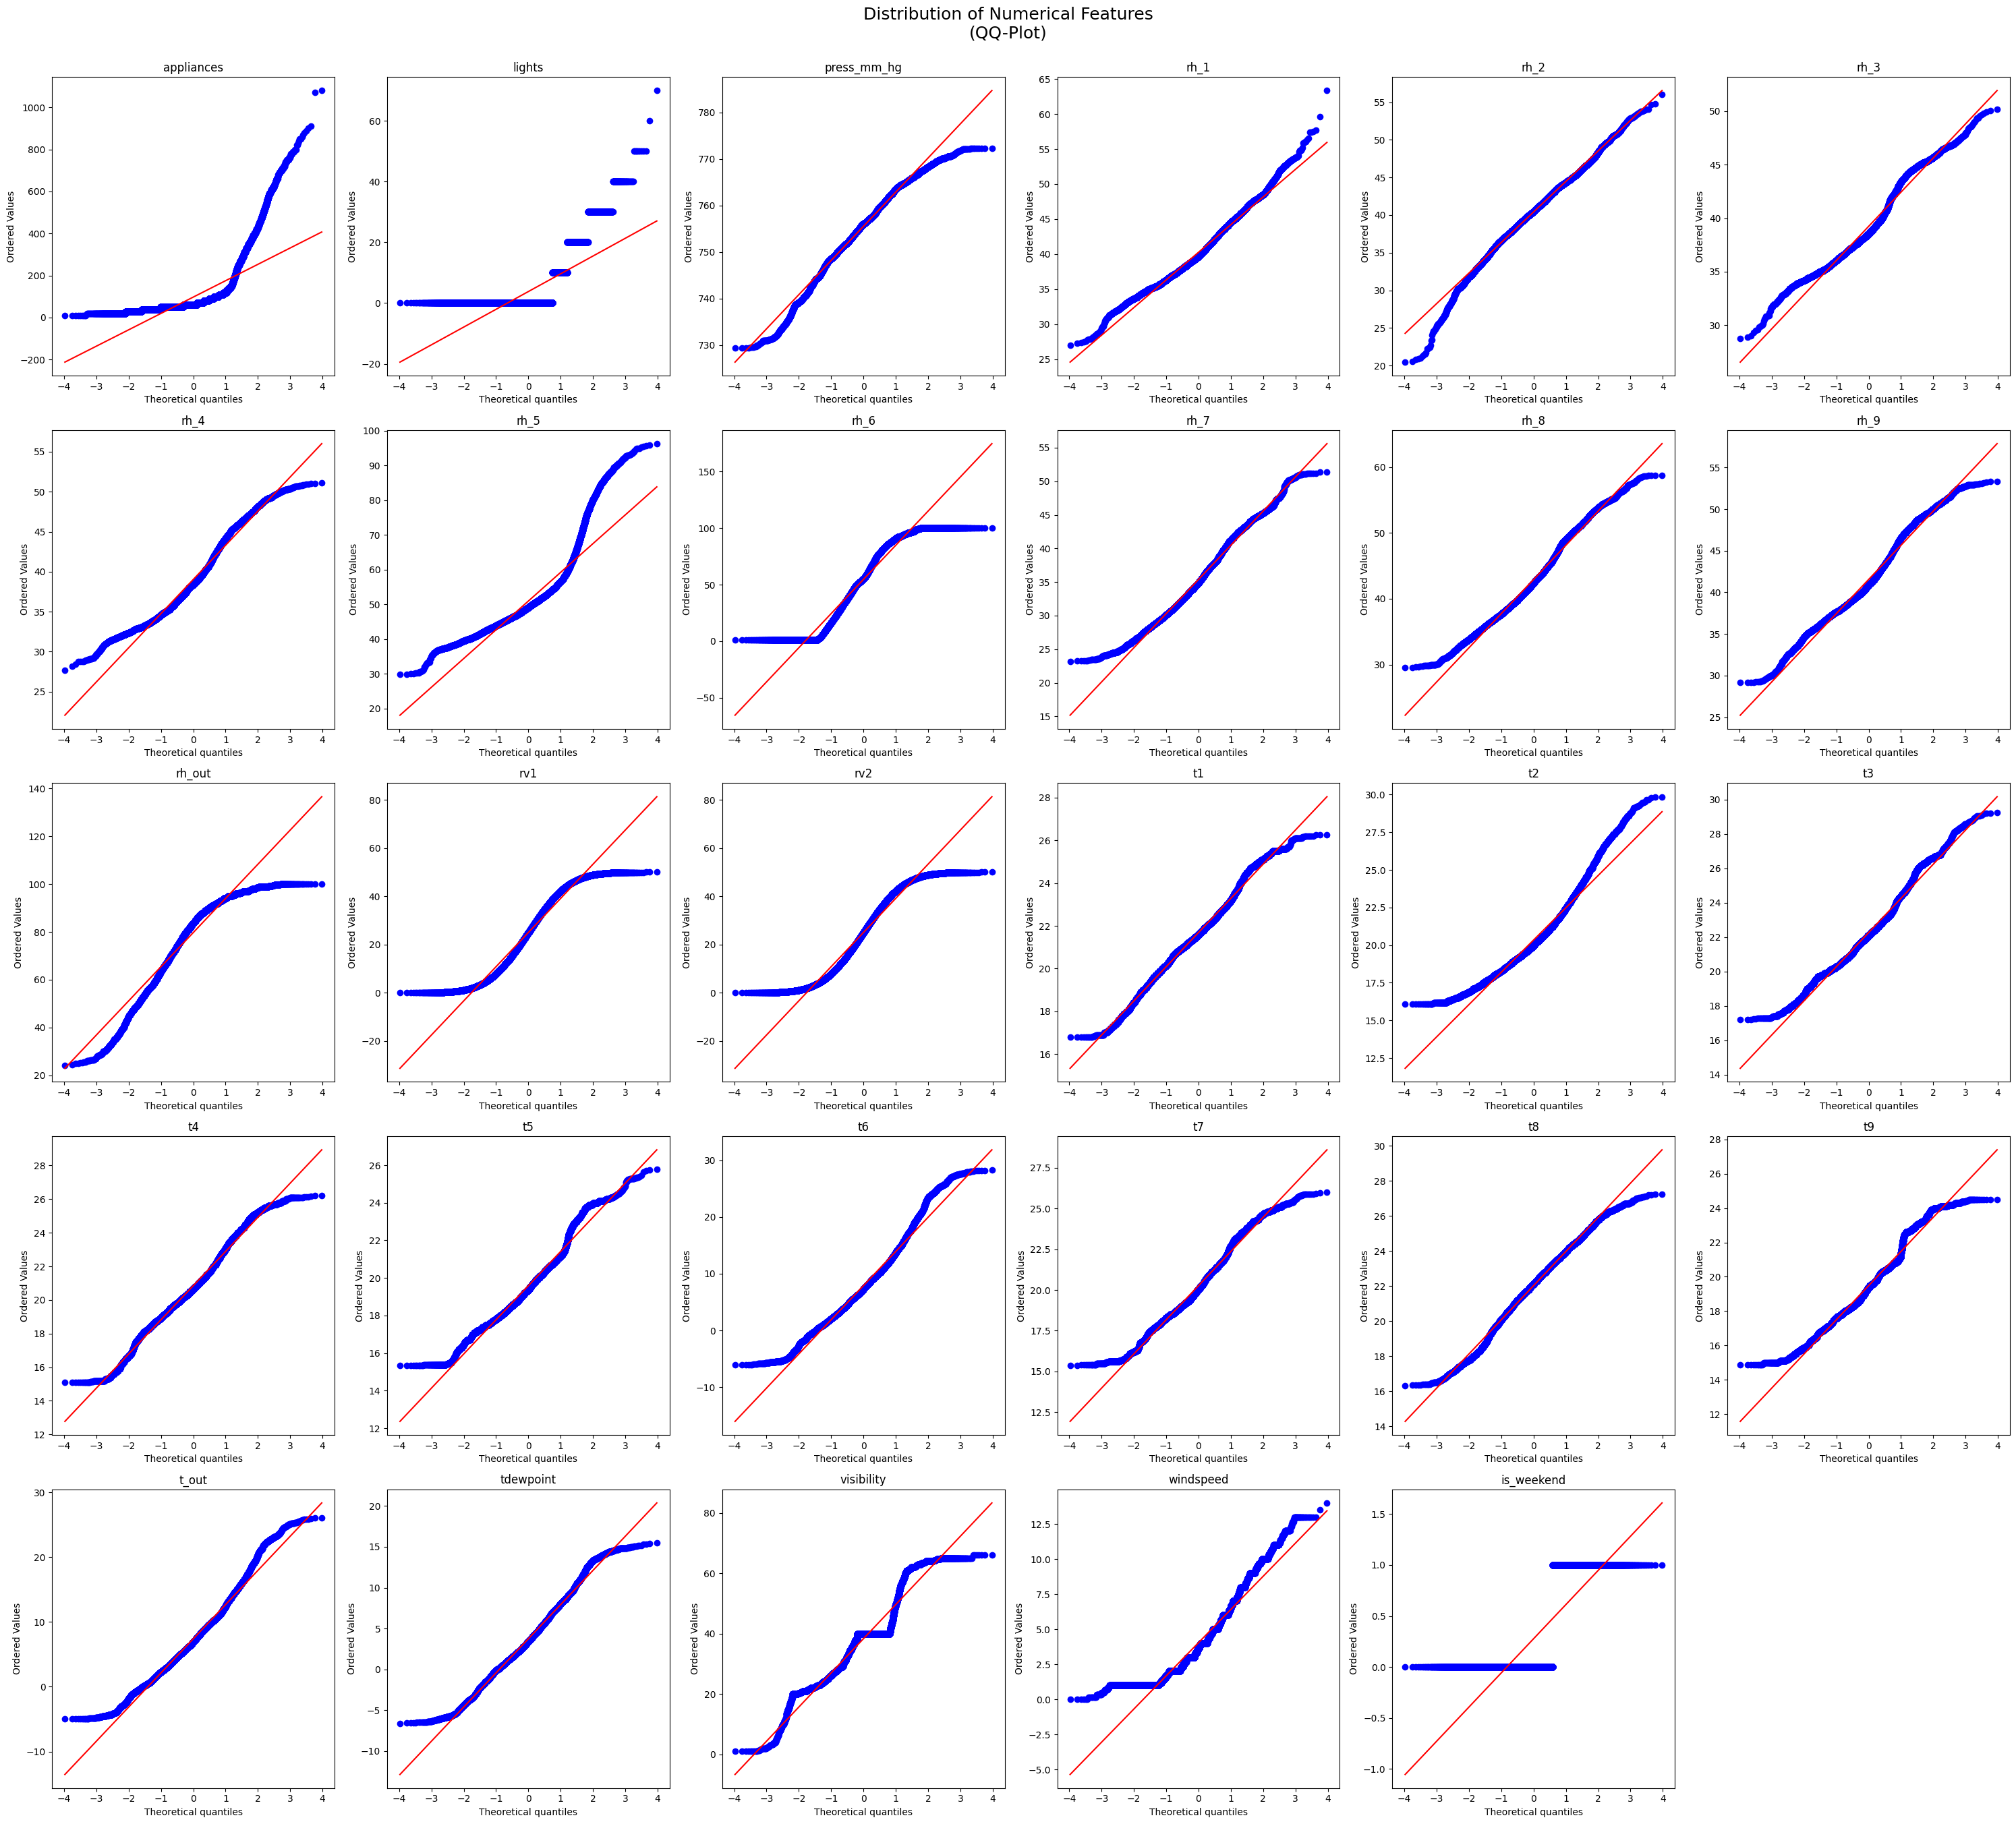

In [15]:
nrows= 5
ncols= np.ceil(len(df.columns)/nrows).astype(int)

fig, axes= plt.subplots(nrows= nrows, ncols= ncols, figsize= (30, 27))
axes= axes.flatten()

# plt.subplots_adjust(hspace=0.5)


for i, feature in enumerate(df.drop(columns= ["date"]).columns): 
    probplot(df[feature], dist="norm", plot=axes[i])
    axes[i].set_title(feature)

    
for i in range(len(df.drop(columns= ["date"]).columns), nrows * ncols):
    fig.delaxes(axes[i])

suptitle= fig.suptitle("Distribution of Numerical Features\n(QQ-Plot)", fontsize=18)
# plt.subplots_adjust(hspace=0.5)
suptitle.set_y(1.0)

plt.tight_layout()
plt.show()

most columns seem to be normally distributed, except for windspeed, rv2, rv1, visibility, t2, rh_6, rh_5 and rh_out

In [16]:
len(df.loc[df["rv1"]==df["rv2"]])== len(df)

True

In [17]:
#rv1 and rv2 always have the same values, so we can remove one of them

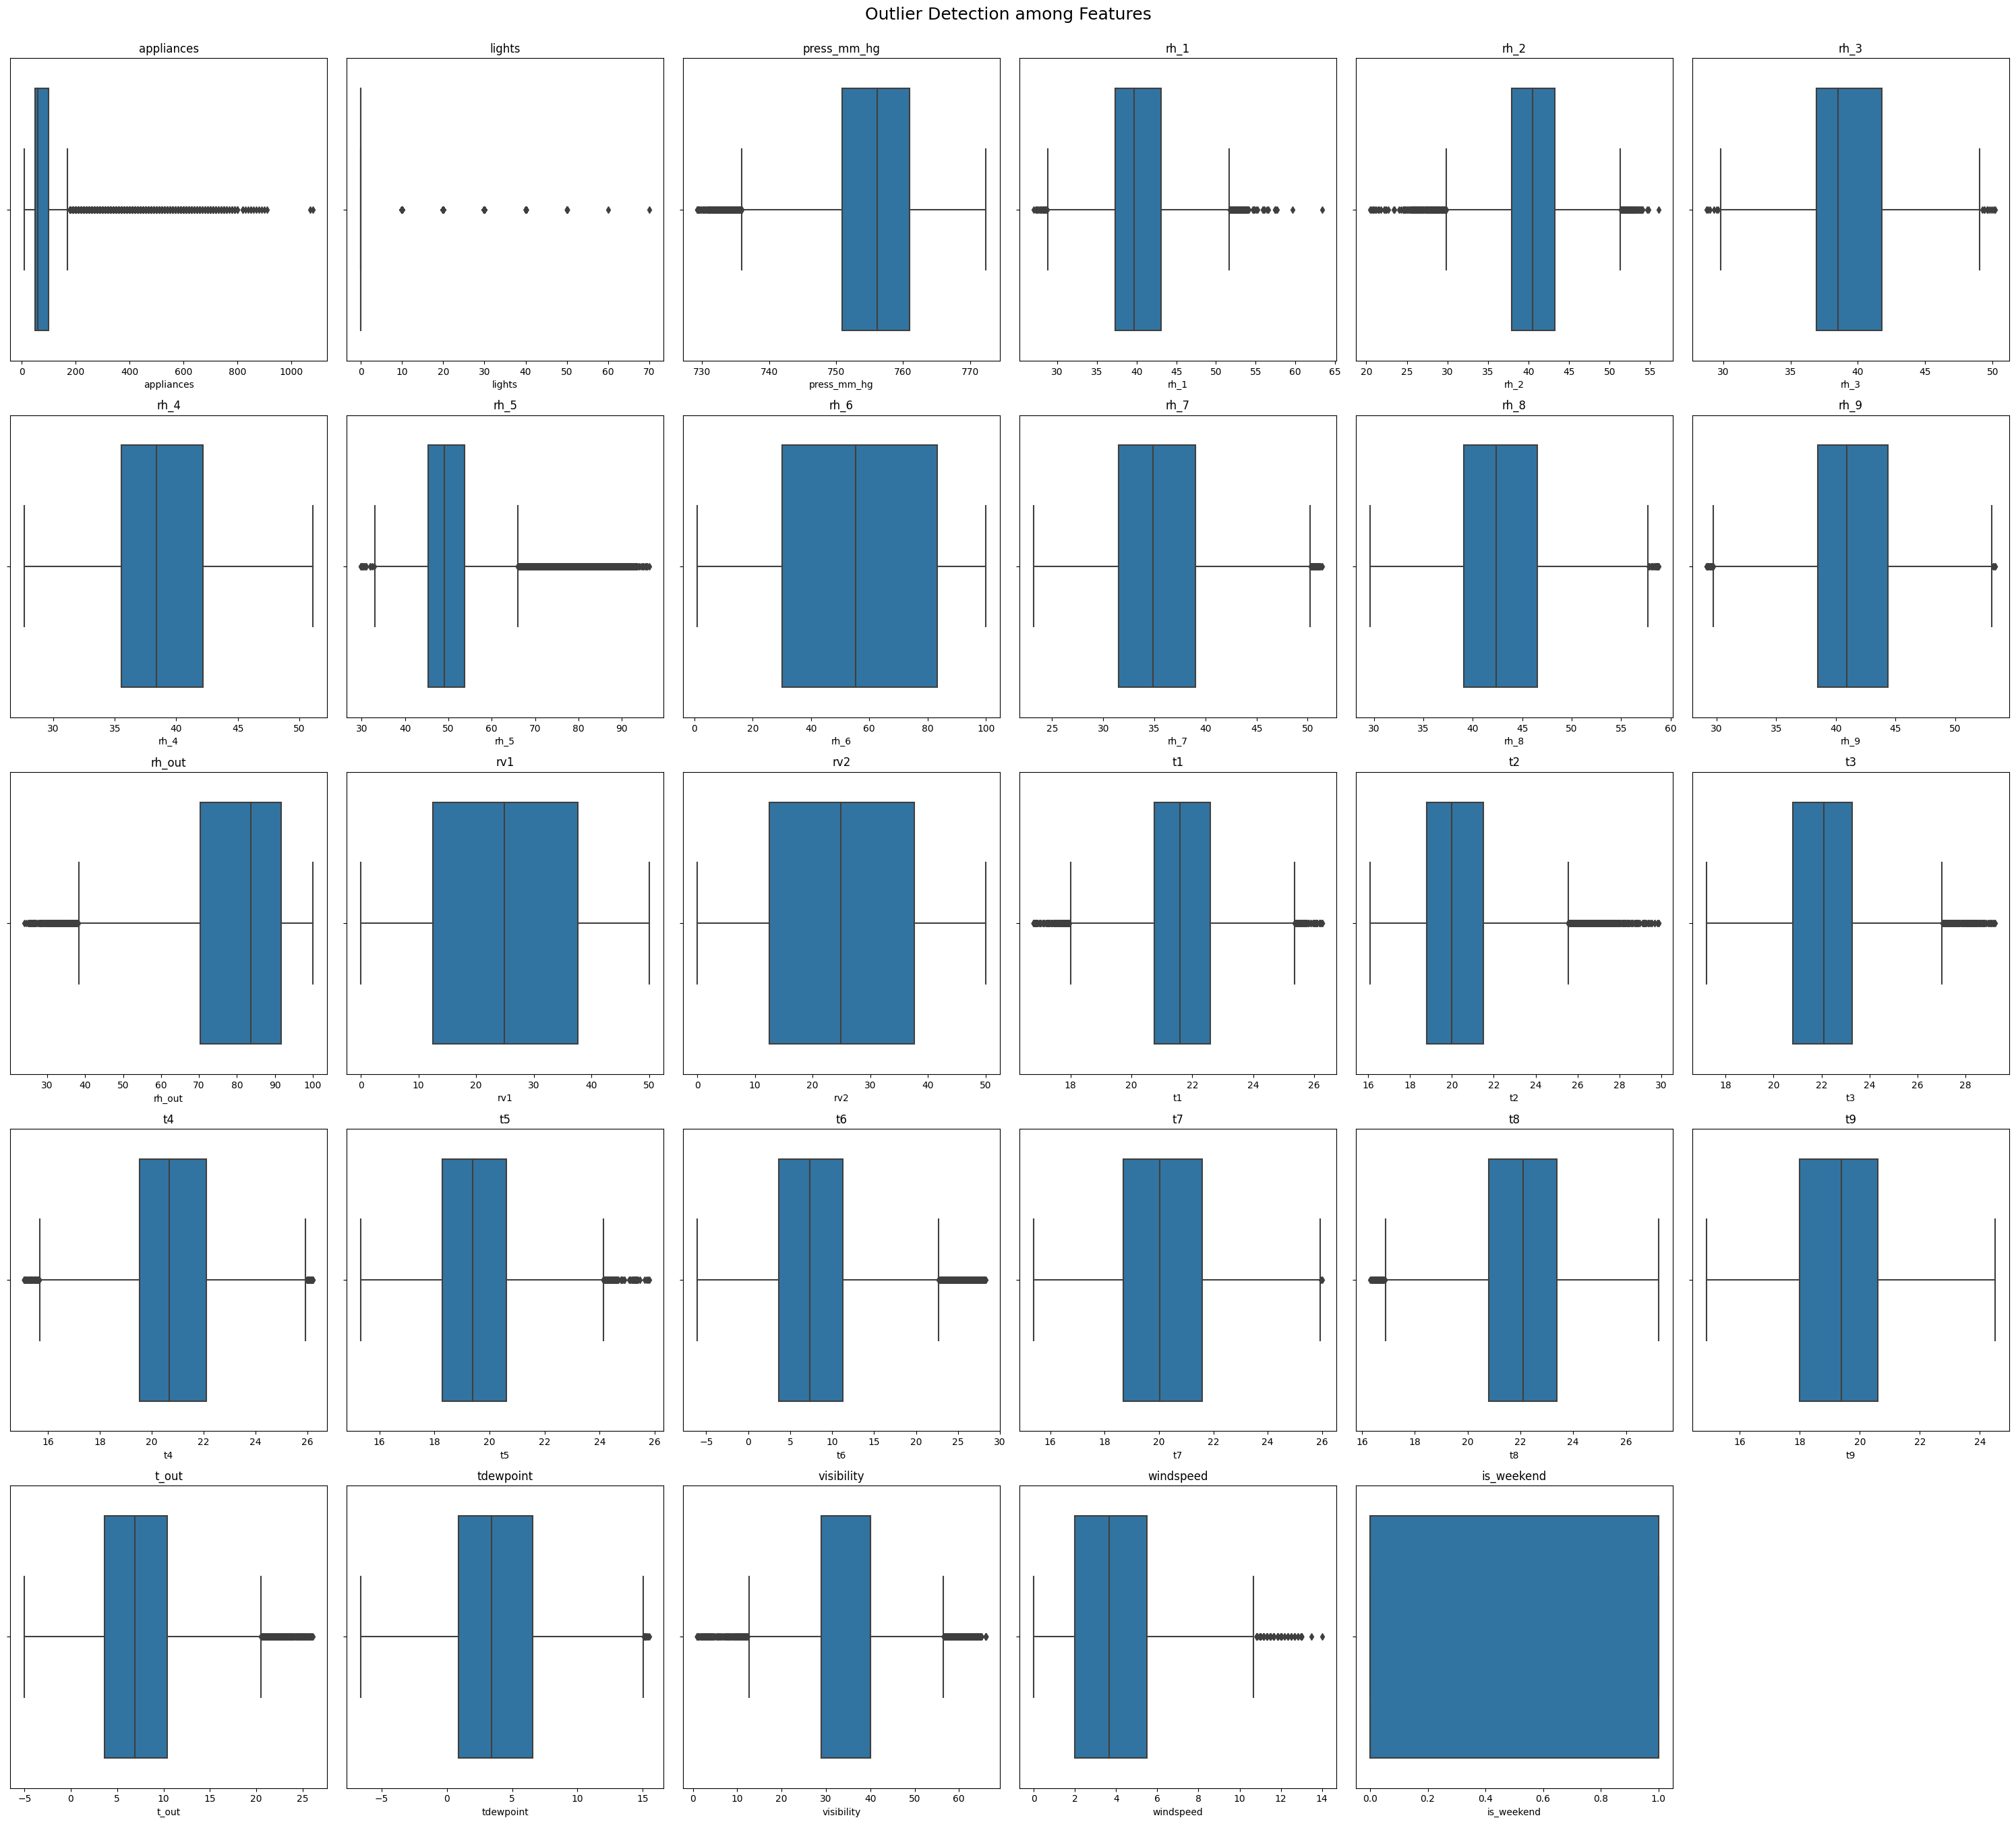

In [18]:
nrows= 5
ncols= np.ceil(len(df.columns)/nrows).astype(int)

fig, axes= plt.subplots(nrows= nrows, ncols= ncols, figsize= (30, 27))
axes= axes.flatten()

# plt.subplots_adjust(hspace=0.05, wspace= 0.0005)


for i, feature in enumerate(df.drop(columns= ["date"]).columns):
    sns.boxplot(data= df, x= feature, ax= axes[i])
    axes[i].set_title(feature)

    
for i in range(len(df.drop(columns= ["date"]).columns), nrows * ncols):
    fig.delaxes(axes[i])

suptitle= fig.suptitle("Outlier Detection among Features", fontsize=18)
suptitle.set_y(1.0)

plt.tight_layout()
plt.show()

features- press_mm_hg, rh_1, rh_2, rh_3, rh_5, rh_7, rh_8, rh_9, rh_out, t1, t2, t3, t4, t5, t6, t7, t8, t_out, tdewpoint, visibility, windspeed all have outliers, which need to be treated before further model development.

In [19]:
df["lights"].value_counts()

lights
0     15252
10     2212
20     1624
30      559
40       77
50        9
70        1
60        1
Name: count, dtype: int64

lights feature can be treated as a categorical variable, as the numbers of lights is always one of the 8 given values, also one value (0) significantly dominates the others.

    We can either map the 0 value as 0 and the rest as 1, or perform one hot encoding.
    The first option seems better as 0 is quite dominant with more than 15000 entries out of a total of 19,735.

In [20]:
df["lights"]= np.where(df["lights"]==0, 0, 1)

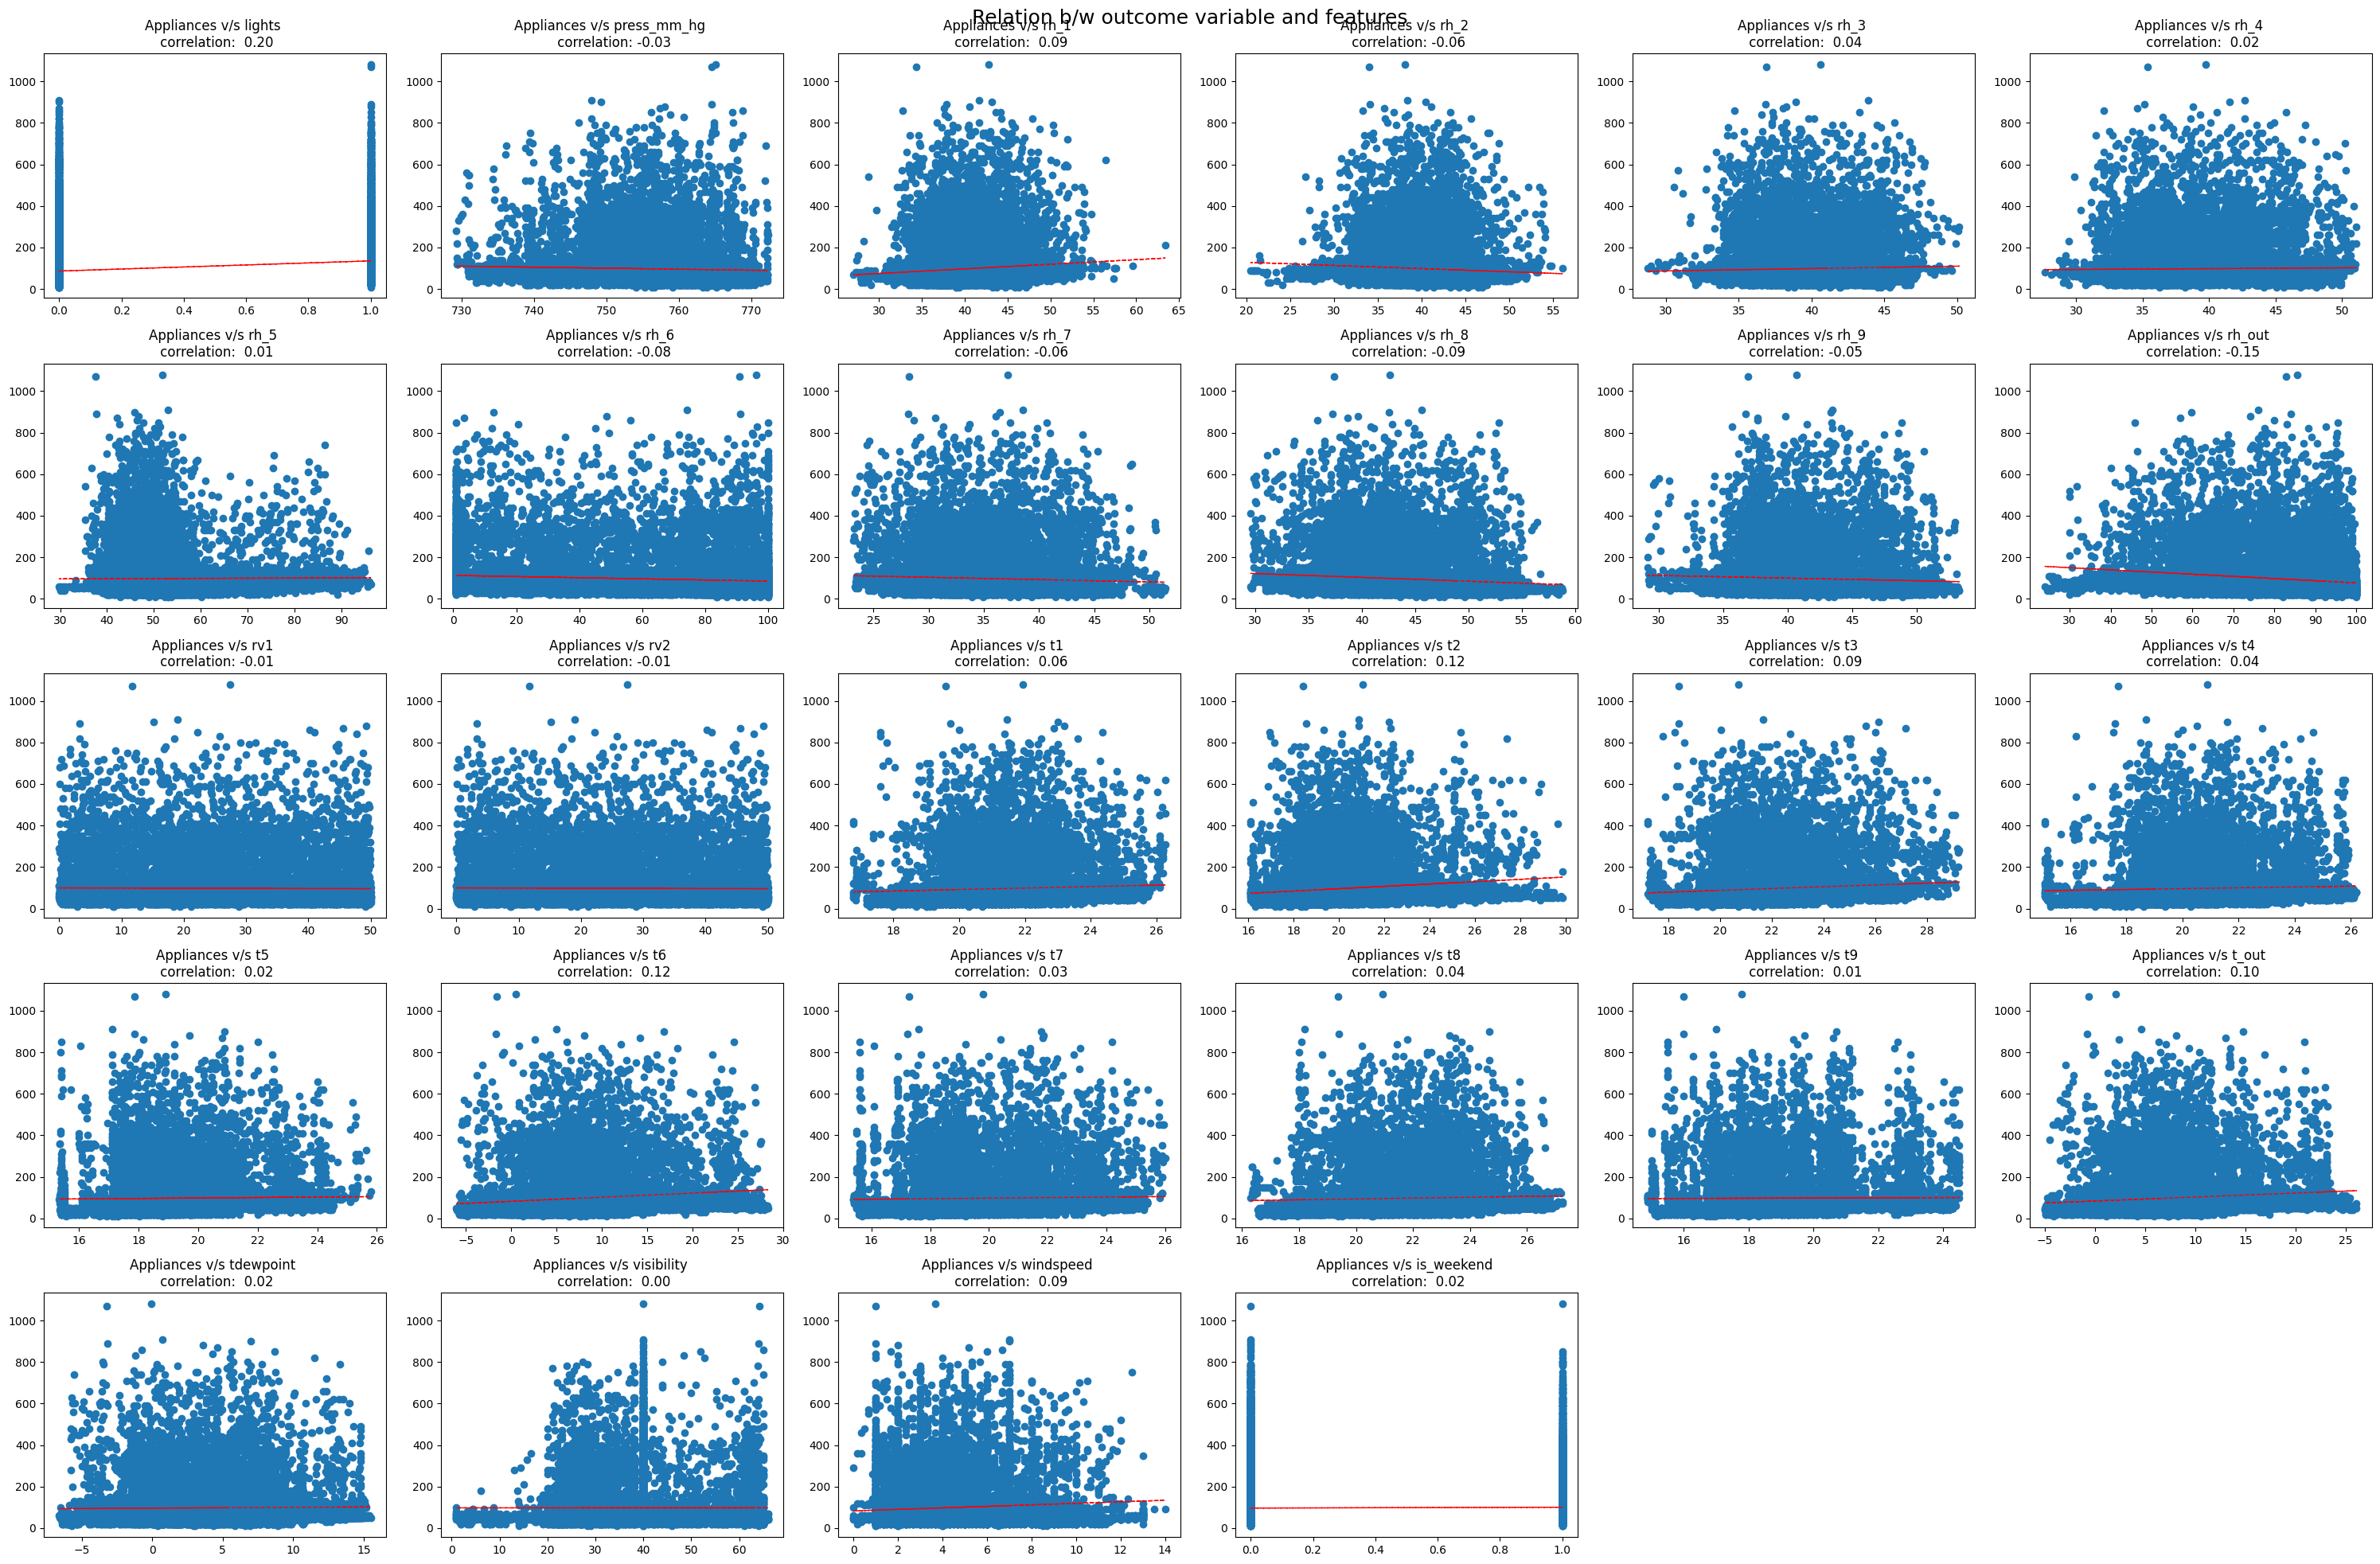

In [21]:
#bivariate analysis

nrows= 5
ncols= np.ceil(len(df.columns)/nrows).astype(int)

fig, axes= plt.subplots(nrows= nrows, ncols= ncols, figsize= (30, 20))
axes= axes.flatten()

# plt.subplots_adjust(hspace=0.5)


for i, col in enumerate(df.drop(columns= ["appliances", "date"]).columns):
    
    feature= df[col]
    outcome_var= df["appliances"]
    correlation= feature.corr(outcome_var)
    axes[i].scatter(feature, outcome_var)
    axes[i].set_title(f"Appliances v/s {col} \n correlation: {correlation: .2f}")
    
    #adding a least square line
    z= np.polyfit(feature, outcome_var, deg= 1)
    y_hat= np.poly1d(z)(feature)
    
    axes[i].plot(feature, y_hat, "r--", lw= 1)
    
for i in range(len(df.drop(columns= ["appliances", "date"]).columns), nrows * ncols):
    fig.delaxes(axes[i])


fig.suptitle("Relation b/w outcome variable and features", fontsize=18)

plt.tight_layout()
plt.show()

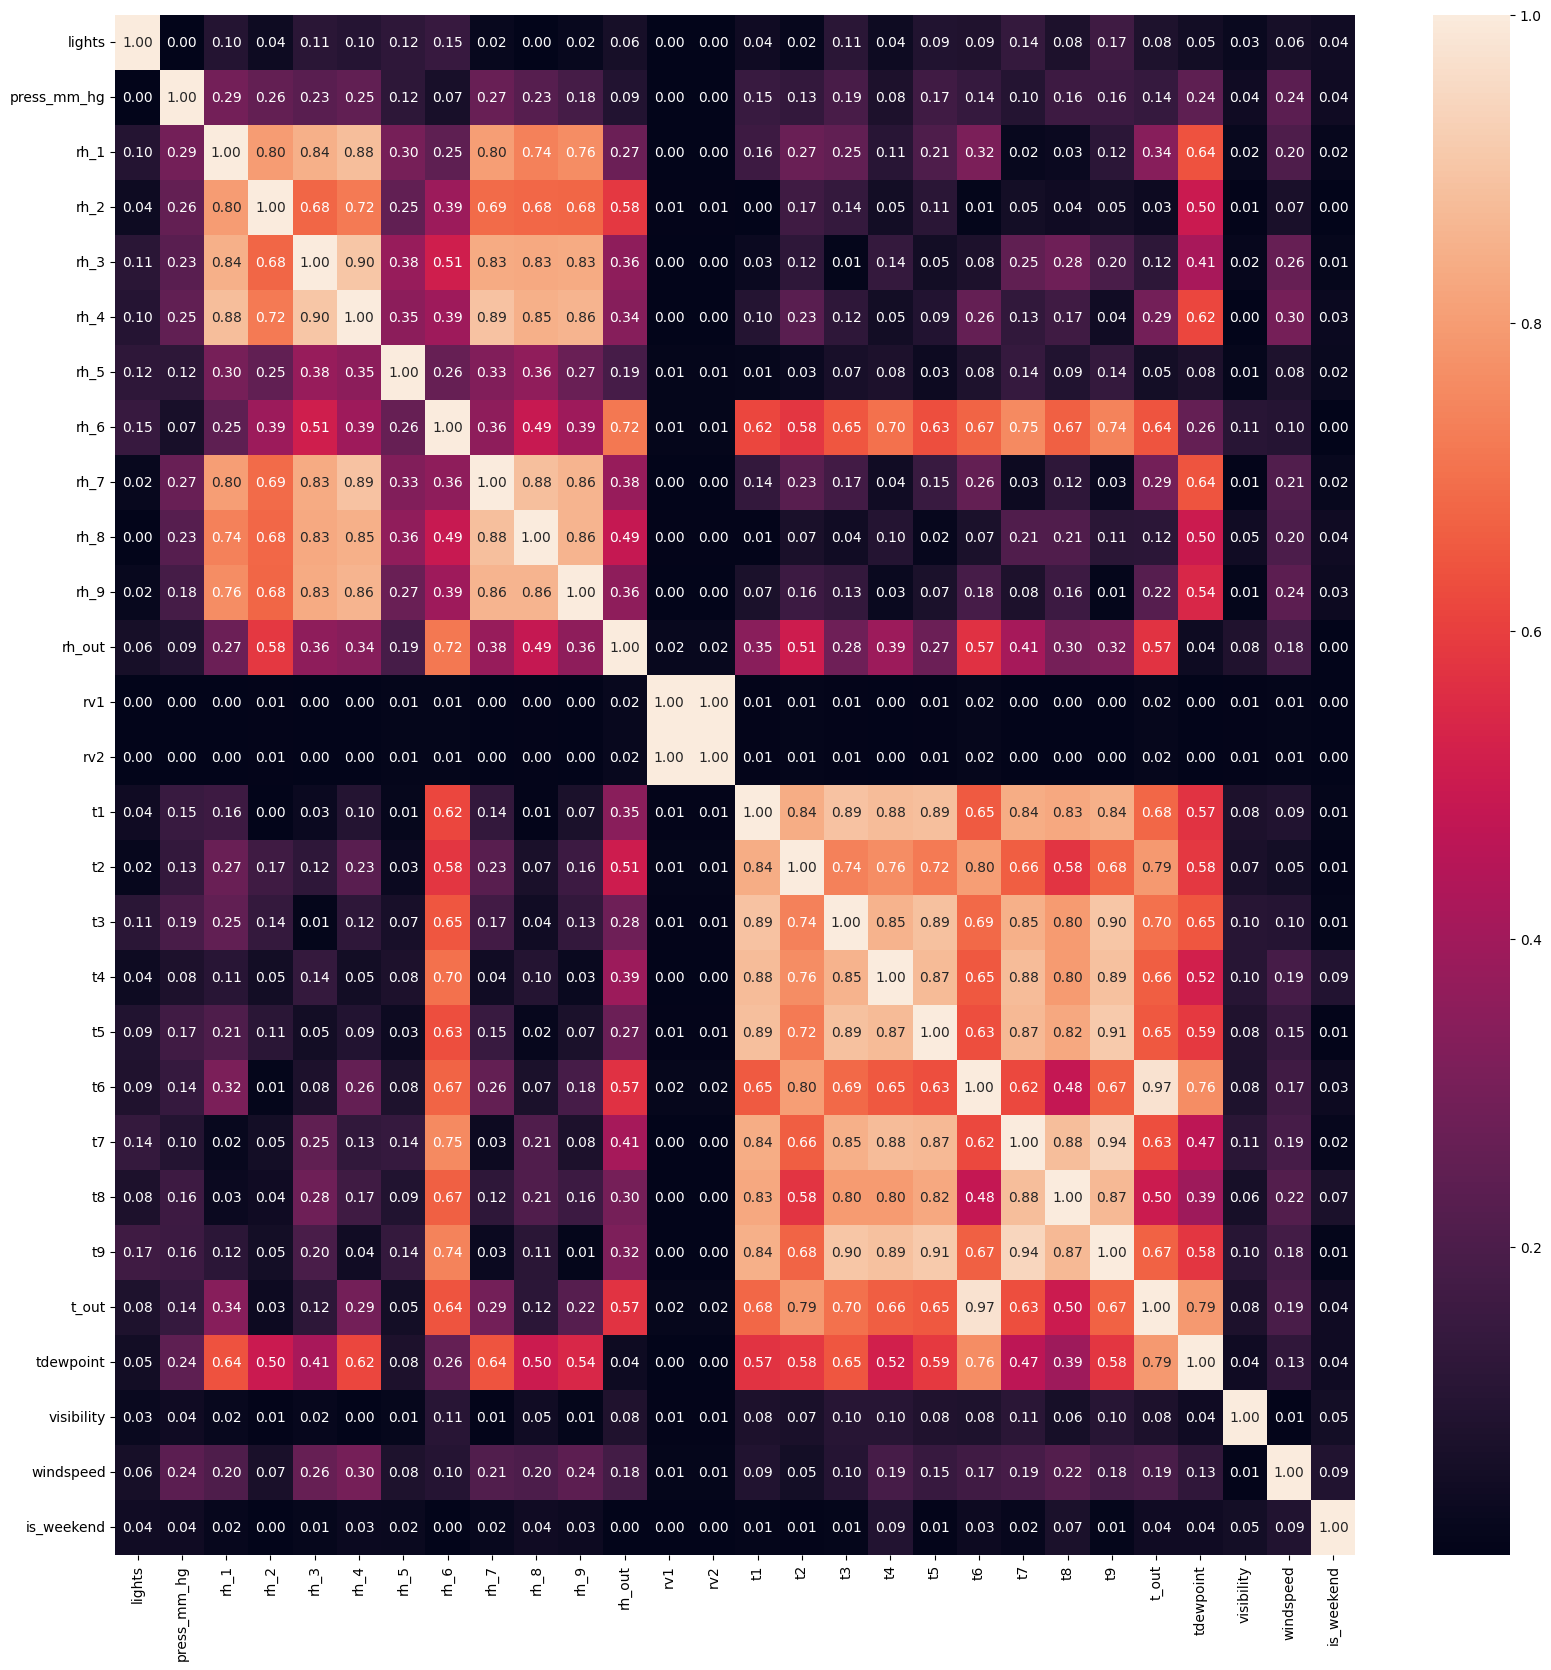

In [22]:
#multivariate analysis
#correlation chart

fig= plt.figure(figsize= (20, 20))
sns.heatmap(abs(df.drop(columns= ["appliances", "date"]).corr()), annot= True, fmt= ".2f")
plt.show()

In [23]:

#dealing with multicollinearity using VIF


from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):
    vif= pd.DataFrame()
    vif["variables"]= df.columns
    vif["VIF"]= [variance_inflation_factor(df.values, i)  for i in range(df.shape[1])]
    
    return vif.sort_values(by='VIF',ascending=False).reset_index(drop=True)

In [24]:
calc_vif(df.drop(columns= ["appliances", "date"]))

,variables,VIF
0,rv2,inf
1,rv1,inf
2,t1,3609.911100
3,t9,2604.830627
4,t2,2503.598869
5,rh_2,2175.056095
6,press_mm_hg,2085.308242
7,rh_1,1654.255066
8,t7,1620.137173
9,rh_3,1571.378435


In [25]:
def vif_calculator_and_feature_dropper(df):
    df_copy= df.copy()
    while True:
        vif_df= calc_vif(df_copy)
        if vif_df.iloc[0,1]>10.0:
            df_copy= df_copy.drop(columns= [vif_df.iloc[0, 0]])
        else:
            break
    return vif_df

In [26]:
final_features= vif_calculator_and_feature_dropper(df.drop(columns= ["appliances", "date"]))
final_features

,variables,VIF
0,visibility,6.130750
1,rh_6,4.110778
2,windspeed,3.582561
3,rv1,3.394352
4,tdewpoint,1.849419
5,is_weekend,1.376639
6,lights,1.325799


In [27]:
final_features_li= list(final_features.loc[:, "variables"])
final_features_li

['visibility', 'rh_6', 'windspeed', 'rv1', 'tdewpoint', 'is_weekend', 'lights']

# ****Model Building****

In [28]:
X= df_model.drop(columns= ["appliances"])
y= df_model["appliances"]

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [31]:
#importing ml models for regression

from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor)
from xgboost import XGBRegressor

In [32]:
#finding the best ml model

models= {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "KNeigghborsRegressor": KNeighborsRegressor(),
    "SVR": SVR(kernel= "rbf"),
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor(),
    "XGBRegressor": XGBRegressor()
}

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    FunctionTransformer, StandardScaler, PowerTransformer)
from scipy import stats

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    mean_squared_error, r2_score)

from sklearn.model_selection import (
    cross_val_score, KFold)

In [34]:
meta_data_00= []

for name, model in tqdm(models.items()):
    model_data= {}
    model_data["name"]= name
    model.random_state = 42
    kfold= KFold(n_splits= 5, shuffle= True, random_state= 42)
    scores= cross_val_score(
        model, X_train.drop(columns= ["date"]), y_train, 
        cv= kfold, scoring= "neg_mean_squared_error", error_score='raise'
    )
    model_data["average rmse"]= np.mean(np.sqrt(-scores))
    meta_data_00.append(model_data)

100%|██████████| 9/9 [04:25<00:00, 29.52s/it]


In [35]:
model_rmse_df= pd.DataFrame(meta_data_00).sort_values("average rmse").reset_index(drop= True)
model_rmse_df

,name,average rmse
0,ExtraTreesRegressor,73.650089
1,RandomForestRegressor,76.553127
2,XGBRegressor,78.488276
3,GradientBoostingRegressor,88.872604
4,KNeigghborsRegressor,93.237755
5,Ridge Regression,93.879561
6,Linear Regression,93.879609
7,Lasso Regression,94.038169
8,SVR,107.894833


In [36]:
print(f"since {model_rmse_df.iloc[0,0]}, {model_rmse_df.iloc[1,0]} and {model_rmse_df.iloc[2,0]} have given the best rmse scores, we'll perform hyperparameter tuning on the same and work forward.")

since ExtraTreesRegressor, RandomForestRegressor and XGBRegressor have given the best rmse scores, we'll perform hyperparameter tuning on the same and work forward.


In [37]:
model_param= {
    ExtraTreesRegressor(): {"n_estimators": [50, 100, 200, 500], "max_depth": [None, 10, 20, 30], 
                            "bootstrap": [True, False], "max_features": [None, "sqrt", "log2"]},
    RandomForestRegressor(): {"n_estimators": [50, 100, 200, 500], "max_features": [None, "sqrt", "log2"],
                              "bootstrap": [True, False], "max_depth": [None, 10, 20, 30],},
    XGBRegressor(): {"n_estimators": [50, 100, 200, 500], "learning_rate": [0.01, 0.1, 0.2],
                     "max_depth": [3, 4, 5], "gamma": [0, 1, 5], "reg_alpha": [0, 0.01, 0.1], 
                     "reg_lambda": [0, 0.01, 0.1],}
}

In [38]:
from skopt import BayesSearchCV

In [39]:
meta_data_01= []

for model, param_grid in tqdm(model_param.items()):

    model_info= {}
    model.random_state = 42
    
    bayes_cv= BayesSearchCV(
        model, param_grid, scoring= "neg_mean_squared_error",
        cv= 5, n_jobs= -1, error_score='raise'
    )
    bayes_cv.fit(X_train.drop(columns= ["date"]), y_train)
    
    model_info["best estimator"]= bayes_cv.best_estimator_
    model_info["best rmse"]= np.sqrt(-bayes_cv.best_score_)
    
    meta_data_01.append(model_info)

100%|██████████| 3/3 [1:33:56<00:00, 1878.80s/it]


In [49]:
best_estimator_meta_df= pd.DataFrame(meta_data_01).sort_values("best rmse").reset_index(drop= True)
best_estimator_meta_df

,best estimator,best rmse
0,"(ExtraTreeRegressor(max_features='log2', rando...",70.582720
1,"(DecisionTreeRegressor(max_depth=30, max_featu...",70.668875
2,"XGBRegressor(base_score=None, booster=None, ca...",77.055563


In [51]:
best_estimator_meta_df.iloc[0, 0]

ExtraTreesRegressor(max_features='log2', n_estimators=200, random_state=42)

In [50]:
best_estimator_meta_df.iloc[1, 0]

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2',
                      n_estimators=500, random_state=42)

In [52]:
best_estimator_meta_df.iloc[2, 0]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [53]:
def is_weekend(df):
    df['is_weekend'] = np.where(df.iloc[:, 0].dt.dayofweek> 4, 1, 0)
    return df[['is_weekend']]

In [48]:
def iqr_outlier_correction(df):
    lower_quantile = np.percentile(df, 25)
    upper_quantile = df.quantile(0.75)
    df = np.where(df < lower_quantile, lower_quantile, df)
    df = np.where(df > upper_quantile, upper_quantile, df)
    return df

In [56]:
#col_index_abnormal
li= ["windspeed", "rv2", "rv1", "visibility", "t2", "rh_6", "rh_5", "rh_out"]
col_index_abnormal= [i for i, feature in enumerate(X_train.columns) if feature in li]
col_index_abnormal

[7, 8, 12, 13, 14, 16, 26, 27]

In [55]:
#col_index_outliers
li= ["press_mm_hg", "rh_1", "rh_2", "rh_3", "rh_5", "rh_7", "rh_8", "rh_9", "rh_out", "t1", "t2", "t3", "t4", "t5", "t6", "t7", "t8", "t_out", "tdewpoint", "visibility", "windspeed"]
col_index_outliers= [i for i, feature in enumerate(X_train.columns) if feature in li]
col_index_outliers

[2, 3, 4, 5, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27]

In [48]:
feature_engineering= ColumnTransformer([
    (
        'date_transformer', 
        FunctionTransformer(is_weekend, validate=False), 
        [0]
    ),
    (
        "outlier treatment",
        FunctionTransformer(iqr_outlier_correction, validate=False),
        col_index_outliers
    ),
    (
        "drop rv1 and rv2",
        "drop",
        [13, 14]
    ),
    (
        "treating skewness",
        PowerTransformer(),
        col_index_abnormal
    )
],
    remainder= StandardScaler()
)

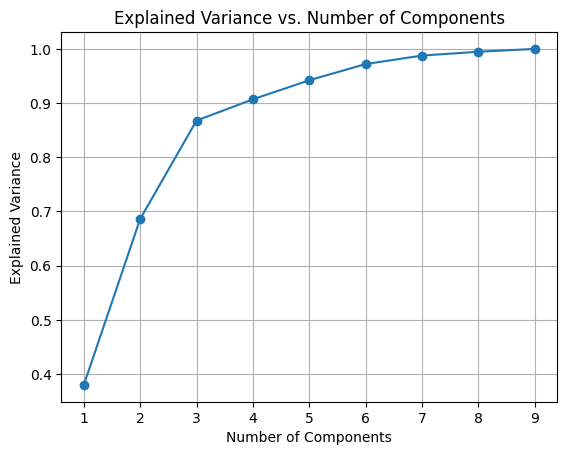

In [50]:
# Create a list to store explained variances
explained_variances = []

X_scaled= feature_engineering.fit_transform(X_train)

# Define the range of candidate component numbers
n_components_range = range(1, X_scaled.shape[1] + 1)

# Perform PCA for each number of components and store the explained variance
for n_components in n_components_range:

    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    explained_variances.append(pca.explained_variance_ratio_.sum())

# Plot the explained variance as a function of the number of components
plt.plot(n_components_range, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE

In [ ]:
meta_data_03 = []

for n in tqdm([5, 10, 15, 20, 25]):
    dic= {}
    dic["n"]= n
    # Create a pipeline with RFE and your model
    rf_pipeline = Pipeline([
        ("Feature Engineering", 
         feature_engineering),
        ("Feature Selection", 
         RFE(
             estimator=RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                                             n_estimators=500, random_state=42),
            n_features_to_select=n)
        ),
        ("Model", 
         RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                               n_estimators=500, random_state=42))
    ])

    # Perform cross-validation and compute the mean R-squared score
    scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='r2')
    mean_r2 = scores.mean()

    # Store the result for this value of n_features_to_select
    dic["mean_r2"] = mean_r2
    
    meta_data_03.append(dic)

In [ ]:
n_df= pd.DataFrame(meta_data_03).sort_values("mean_r2")
n_df

In [65]:
rf_pipeline= Pipeline([
    (
        "Feature Engineering",
        feature_engineering
    ),
#     (
#         "PCA",
#         PCA(n_components= 12)
#     ),
    (
        "Feature Selection",
        RFE(
            estimator=RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                                            n_estimators=500, random_state=42),
            n_features_to_select=10  # Adjust the number of features as needed
        )
    ),
    (
        "Model",
        RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                              n_estimators=500, random_state=42)
    )
])
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Engineering',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('date_transformer',
                                                  FunctionTransformer(func=<function is_weekend at 0x79e7f47368c0>),
                                                  [0]),
                                                 ('outlier treatment',
                                                  FunctionTransformer(func=<function iqr_outlier_correction at 0x79e7d5708670>),
                                                  [2, 3, 4, 5, 7, 9, 10, 11, 12,
                                                   15, 16, 17, 18, 19, 20, 21,
                                                   22, 24, 25, 26, 27]),
                                                 ('drop rv1 a...
                                                  [13, 14]),
                                                 ('treating skewness',
                                                  PowerTransformer(),
                                                  [7, 8, 12, 13, 14, 16, 26,
                                                   27])])),
                ('Feature Selection',
                 RFE(estimator=RandomForestRegressor(bootstrap=False,
                                                     max_depth=20,
                                                     max_features='log2',
                                                     n_estimators=500,
                                                     random_state=42),
                     n_features_to_select=10)),
                ('Model',
                 RandomForestRegressor(bootstrap=False, max_depth=20,
                                       max_features='log2', n_estimators=500,
                                       random_state=42))])

In [29]:
def model_analysis(y, y_hat):
    mse= mean_squared_error(y**2, y_hat**2)
    r2= r2_score(y**2, y_hat**2)
    return {"MSE": mse,
            "RMSE": np.sqrt(mse),
            "r2_score(test dataset)": r2}

In [66]:
y_pred = rf_pipeline.predict(X_test)

print(f"r2 score(train dataset): {rf_pipeline.score(X_train, y_train)}")
model_analysis(y_test, y_pred)

r2 score(train dataset): 0.9924557596290022


{'MSE': 2114979698.7117677,
 'RMSE': 45988.9084314008,
 'r2_score(test dataset)': 0.38107236221322993}

r2 score(train dataset): 0.9946762061260218


{'MSE': 2164614248.5345263,
 'RMSE': 46525.41508180799,
 'r2_score(test dataset)': 0.3665473080516597}

In [26]:
et_pipeline= Pipeline([
    (
        "Feature Engineering",
        feature_engineering
    ),
    (
        "PCA",
        PCA(n_components= 15)
    ),
    (
        "Model",
        ExtraTreesRegressor(max_depth=30, max_features='sqrt', 
                            n_estimators=200,random_state=42)
    )
])
et_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Engineering',
                 ColumnTransformer(remainder=PowerTransformer(),
                                   transformers=[('drop date', 'drop', [0])])),
                ('PCA', PCA(n_components=15)),
                ('Model',
                 ExtraTreesRegressor(max_depth=30, max_features='sqrt',
                                     n_estimators=200, random_state=42))])

In [27]:
y_pred= et_pipeline.predict(X_test)

In [28]:
print(f"r2 score(train dataset): {et_pipeline.score(X_train, y_train)}")
model_analysis(y_test, y_pred)

r2 score(train dataset): 0.99979516060823


{'MSE': 2429211433.4884343,
 'RMSE': 49287.0310881923,
 'r2_score(test dataset)': 0.2891155905045355}

In [29]:
from sklearn.neighbors import LocalOutlierFactor

def calculate_lof(X, lof_model):
    lof_scores = -lof_model.fit_predict(X)
    return np.c_[X, lof_scores]

In [30]:

lof_et_pipeline= Pipeline([
    (
        "Feature Engineering",
        feature_engineering
    ),
    (
        "outlier treatment",
        FunctionTransformer(
            func=calculate_lof, validate=False,
            kw_args={
                'lof_model': LocalOutlierFactor(
                    n_neighbors=20, contamination=0.05)
            })
    ),
    (
        "PCA",
        PCA(n_components= 15)
    ),
    (
        "Model",
        ExtraTreesRegressor(max_depth=30, max_features='sqrt', 
                            n_estimators=200,random_state=42)
    )
])
lof_et_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Engineering',
                 ColumnTransformer(remainder=PowerTransformer(),
                                   transformers=[('drop date', 'drop', [0])])),
                ('outlier treatment',
                 FunctionTransformer(func=<function calculate_lof at 0x7ca0c87df520>,
                                     kw_args={'lof_model': LocalOutlierFactor(contamination=0.05)})),
                ('PCA', PCA(n_components=15)),
                ('Model',
                 ExtraTreesRegressor(max_depth=30, max_features='sqrt',
                                     n_estimators=200, random_state=42))])

In [32]:
y_pred= lof_et_pipeline.predict(X_test)

In [33]:
print(f"r2 score(train dataset): {et_pipeline.score(X_train, y_train)}")
model_analysis(y_test, y_pred)

r2 score(train dataset): 0.99979516060823


{'MSE': 2495917200.389786,
 'RMSE': 49959.15532101985,
 'r2_score(test dataset)': 0.26959481554856046}

In [35]:
from sklearn.ensemble import IsolationForest

def apply_isolation_forest(X):
    isolation_forest = IsolationForest(contamination= "auto")
    labels = isolation_forest.fit_predict(X)
    
    return np.c_[X, labels]

In [40]:
if_et_pipeline= Pipeline([
    (
        "Feature Engineering",
        feature_engineering
    ),
    (
        "Isolation Forest", 
        FunctionTransformer(func=apply_isolation_forest, validate=False)
    ),
    (
        "PCA",
        PCA(n_components= 15)
    ),
    (
        "Model",
        ExtraTreesRegressor(max_depth=30, max_features='sqrt', 
                            n_estimators=200,random_state=42)
    )
])

if_et_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Engineering',
                 ColumnTransformer(remainder=PowerTransformer(),
                                   transformers=[('drop date', 'drop', [0])])),
                ('Isolation Forest',
                 FunctionTransformer(func=<function apply_isolation_forest at 0x7ca0911320e0>)),
                ('PCA', PCA(n_components=15)),
                ('Model',
                 ExtraTreesRegressor(max_depth=30, max_features='sqrt',
                                     n_estimators=200, random_state=42))])

In [41]:
y_pred= if_et_pipeline.predict(X_test)

In [42]:
print(f"r2 score(train dataset): {if_et_pipeline.score(X_train, y_train)}")
model_analysis(y_test, y_pred)

r2 score(train dataset): 0.9505748411772981


{'MSE': 2541357576.2714243,
 'RMSE': 50411.87931699655,
 'r2_score(test dataset)': 0.2562971444069907}

In [ ]:
preprocessing_pipeline= Pipeline([
    (
        "Feature Engineering",
        ColumnTransformer([
            ("drop columns", "drop", [0]),
            ("scaling", StandardScaler(), slice(1, None))
        ])
    ),
    (
        "outlier treatment",
        FunctionTransformer(
            func=calculate_lof, validate=False,
            kw_args={
                'lof_model': LocalOutlierFactor(
                    n_neighbors=20, contamination=0.05)
            })
    ),
    (
        "PCA",
        PCA(n_components= 10)
    ),
])


In [ ]:
X_train_preprocessed= preprocessing_pipeline.fit_transform(X_train)

In [ ]:
params= {
    "n_estimators": [100, 200, 500],
    "criterion": ["squared_error", "absolute_error"],
    "max_depth": [10, 50, 100, None],
#     "max_features": ["sqrt", "log2", None],
    "warm_start": [True, False]
}

In [ ]:


bayes_cv= BayesSearchCV(
    ExtraTreesRegressor(max_features= None), 
    search_spaces= params, cv= 3, n_jobs= -1,
    verbose= 1
).fit(X_train_preprocessed, y_train)

In [ ]:
bayes_df= pd.DataFrame(bayes_cv.cv_results_)
bayes_df.sort_values("rank_test_score").head()

In [ ]:
bayes_df["mean_fit_time"].sum()

In [ ]:
bayes_cv.best_params_

In [ ]:
bayes_cv.best_estimator_

In [ ]:
X_test_preprocessed= preprocessing_pipeline.transform(X_test)
y_pred= bayes_cv.predict(X_test_preprocessed)

In [ ]:
model_analysis(y_test, y_pred)

In [ ]:
# final_pipeline= Pipeline([
#     (
#         "preprocessing",
#         preprocessing_pipeline
#     ),
#     (
#         "Model",
#         ExtraTreesRegressor('n_estimators': 500, 'warm_start': True)
#     )
# ])